In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.ndimage 
import pandas
import tensorflow as tf
import cv2
from PIL import Image
import time

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg



root_dir = "/Users/abiola/Documents/EPFL/ML_Project2_Road_Segmentation/Ressources/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)]
gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

print(np.asarray(gt_imgs).shape)
print(np.asarray(imgs).shape)


(100, 400, 400)
(100, 400, 400, 3)


In [ ]:
#First of all we have to chose between offline expansion (expanding our whole dataset beforehand) and online augmentation (expanding mini-batches at each iteration)

#We know that online expansion is preferred for relatively large datasets because we can't necessarily handle the explosive increase in size of the dataset
#Our initial dataset is really small (only 100 elements). Therefore we can apply offline expansion in order to reach several thousands of inputs


#Show image
#cimg = concatenate_images(imgs_flipped[99], gt_imgs_flipped[99])
#fig1 = plt.figure(figsize=(10, 10))
#plt.imshow(cimg, cmap='Greys_r')

import cv2

def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

In [11]:
#1. Flip
def flip_images_lr(imgs,gt_imgs):
    n = len(imgs)
    imgs_flipped = [np.fliplr(imgs[i]) for i in range(n)]
    gt_imgs_flipped = [np.fliplr(gt_imgs[i]) for i in range(n)]
    return imgs_flipped, gt_imgs_flipped

def flip_images_ud(imgs,gt_imgs):
    n = len(imgs)
    imgs_flipped = [np.flipud(imgs[i]) for i in range(n)]
    gt_imgs_flipped = [np.flipud(gt_imgs[i]) for i in range(n)]
    return imgs_flipped, gt_imgs_flipped



def flip_pipeline(imgs,gt_imgs):
    imgs_flipped_lfr, gt_imgs_flipped_lfr = flip_images_lr(imgs,gt_imgs)
    imgs_flipped_ud, gt_imgs_flipped_ud = flip_images_ud(imgs,gt_imgs)
   
    return imgs_flipped_lfr + imgs_flipped_ud,gt_imgs_flipped_lfr+gt_imgs_flipped_ud
    
    
    
    

flip_pipeline(imgs,gt_imgs) 


([array([[[0.28627452, 0.2509804 , 0.21960784],
          [0.30588236, 0.29411766, 0.24705882],
          [0.31764707, 0.29803923, 0.2509804 ],
          ...,
          [0.28235295, 0.2627451 , 0.21960784],
          [0.3529412 , 0.3019608 , 0.23529412],
          [0.39215687, 0.32941177, 0.2627451 ]],
  
         [[0.41960785, 0.3882353 , 0.34509805],
          [0.33333334, 0.30980393, 0.28627452],
          [0.31764707, 0.29803923, 0.27450982],
          ...,
          [0.32941177, 0.3019608 , 0.25882354],
          [0.34901962, 0.29803923, 0.24705882],
          [0.40392157, 0.34117648, 0.2784314 ]],
  
         [[0.2901961 , 0.27450982, 0.28235295],
          [0.21568628, 0.20392157, 0.21176471],
          [0.16470589, 0.16470589, 0.17254902],
          ...,
          [0.39607844, 0.3372549 , 0.2784314 ],
          [0.34901962, 0.3019608 , 0.2509804 ],
          [0.34117648, 0.3254902 , 0.27450982]],
  
         ...,
  
         [[0.30980393, 0.28235295, 0.2627451 ],
          [0.3

(800, 400, 400, 3)


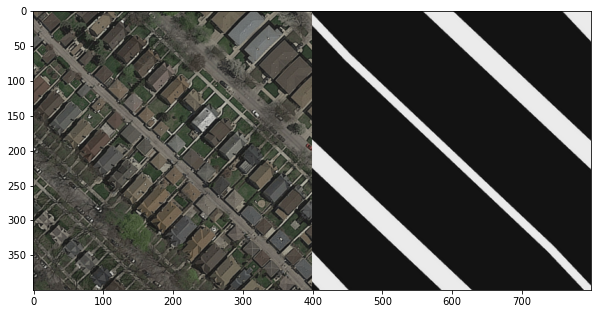

In [12]:
#2. Rotate

def rotate(imgs,gt_imgs,angle):
    n = len(imgs)
    imgs_rot = [scipy.ndimage.interpolation.rotate(imgs[i], angle, axes=(1, 0), reshape=False, output=None, order=3, mode='reflect', cval=0.0, prefilter=True) for i in range(n)]
    #imgs_rot_resized = [cv2.resize(imgs_rot[i], (400,400), interpolation = 0) for i in range(n)]
    gt_imgs_rot = [scipy.ndimage.interpolation.rotate(gt_imgs[i], angle, axes=(1, 0), reshape=False, output=None, order=3, mode='reflect', cval=0.0, prefilter=True) for i in range(n)]
    #gt_imgs_rot_resized = [cv2.resize(gt_imgs_rot[i], (400,400), interpolation = 0) for i in range(n)]
    return imgs_rot,gt_imgs_rot
    

    
def rotatation_pipeline(imgs,gt_imgs,nb_rotations):
    
    imgs_output = []
    gt_imgs_output = []
    stepSize = 360/nb_rotations
    angle = stepSize
    for i in range(nb_rotations):
        imgs_rot_tmp, gt_imgs_rot_tmp = rotate(imgs,gt_imgs,angle)
        imgs_output = imgs_output + imgs_rot_tmp
        gt_imgs_output = gt_imgs_output + gt_imgs_rot_tmp
        angle += stepSize
   
    return imgs_output,gt_imgs_output
    

imgs_rotated, gt_imgs_rotated = rotatation_pipeline(imgs,gt_imgs,8)
print(np.array(imgs_rotated).shape)    
cimg = concatenate_images(imgs_rotated[0],gt_imgs_rotated[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [13]:
#3. Crop

def random_crop_and_resize(image):
    width = image.shape[0]
    cropped_image = tf.image.random_crop(image, size = [125,125,3])
    print(type(image))
    cropped_image = tf.image.resize(cropped_image, [400,400])
    return cropped_image


def crop_and_resize_imgs(imgs,gt_imgs):
    n = len(imgs)
    
    gt_imgs = np.array(gt_imgs).reshape((-1,400,400,1)).tolist()
   
    cropped_imgs = []
    cropped_gt_imgs = []
    #we extract 5 differents crops for each image
    for i in range(1):
      image_crop = tf.image.crop_and_resize(imgs, [[0,0,0.5,0.5],[0.5,0,1,0.5],[0.25,0.25,0.75,0.75],[0,0.5,0.5,1],[0.5,0.5,1,1]], [i,i,i,i,i], [400,400], method='bilinear',extrapolation_value=0.0, name=None)
      gt_image_crop = tf.image.crop_and_resize(gt_imgs, [[0,0,0.5,0.5],[0.5,0,1,0.5],[0.25,0.25,0.75,0.75],[0,0.5,0.5,1],[0.5,0.5,1,1]], [i,i,i,i,i], [400,400], method='bilinear',extrapolation_value=0.0, name=None)

      cropped_imgs.append(image_crop)
      cropped_gt_imgs.append(gt_image_crop)

      print(i)
    
    #cropped_imgs = [tf.image.crop_and_resize(imgs, [[0,0,0.5,0.5],[0.5,0,1,0.5],[0.25,0.25,0.75,0.75],[0,0.5,0.5,1],[0.5,0.5,1,1]], [i,i,i,i,i], [400,400], method='bilinear',extrapolation_value=0.0, name=None) for i in range(100)]
    #cropped_gt_imgs = [tf.image.crop_and_resize(gt_imgs, [[0,0,0.5,0.5],[0.5,0,1,0.5],[0.25,0.25,0.75,0.75],[0,0.5,0.5,1],[0.5,0.5,1,1]], [i,i,i,i,i], [400,400], method='bilinear',extrapolation_value=0.0, name=None) for i in range(100)]

    #we have to adjuste the dimensions
    cropped_imgs = np.array(cropped_imgs).reshape((-1,400,400,3))
    cropped_gt_imgs = np.array(cropped_gt_imgs).reshape((-1,400,400))
    
    return cropped_imgs,cropped_gt_imgs

start = time.time()
#cropped,gt_cropped = crop_and_resize_imgs(imgs,gt_imgs)
end = time.time()

#print("Time elapsed:", (end-start)/60, " minutes")

#print(cropped.shape)
#print(gt_cropped.shape)

#cimg = concatenate_images(imgs[0],gt_imgs[0])
#fig1 = plt.figure(figsize=(10, 10))
#plt.imshow(cimg, cmap='Greys_r')


#cropped = random_crop_and_resize(imgs[0])
#cimg = concatenate_images(cropped[3],gt_cropped[3])
#fig1 = plt.figure(figsize=(10, 10))
#plt.imshow(cimg, cmap='Greys_r')

In [17]:
def data_rotation_flip_pipeline(imgs,gt_imgs):
  # flip vertically and horizontally
  
  imgs_flipped, gt_imgs_flipped = flip_pipeline(imgs,gt_imgs)

  imgs_out = imgs + imgs_flipped
  gt_imgs_out = gt_imgs + gt_imgs_flipped

  print(np.array(imgs_out).shape)
  print(np.array(gt_imgs_out).shape)
  print("\n\n********************* flip step done *************************")

  #rotate by steps of 45 degress 
  
  imgs_rotated, gt_imgs_rotated = rotatation_pipeline(imgs_out,gt_imgs_out,8)

  imgs_out = imgs_rotated
  gt_imgs_out = gt_imgs_rotated

  print(np.array(imgs_out).shape)
  print(np.array(gt_imgs_out).shape)
  print("\n\n********************* rotation step done *************************")
  #extract 5 different crops for each image
  #cropped,gt_cropped = crop_and_resize_imgs(imgs_out,gt_imgs_out)

  #imgs_out = imgs_out + cropped
  #gt_imgs_out = gt_imgs_out + gt_cropped

  for i in range(len(imgs_out)):
    tmp_img = img_float_to_uint8(imgs_out[i])
    tmp_img_gt = img_float_to_uint8(gt_imgs_out[i])
    
    plt.imsave(os.path.join(root_dir + "/out/images/" ,str(i) + ".png"),tmp_img)
    plt.imsave(os.path.join(root_dir + "/out/ground_truth/" ,str(i) + ".png"),tmp_img_gt,cmap='Greys_r')

  print("\n\n********************* write to desk step done *************************")


  return imgs_out,gt_imgs_out


imgs_out,gt_imgs_out = data_rotation_flip_pipeline(imgs,gt_imgs)

(300, 400, 400, 3)
(300, 400, 400)


********************* flip step done *************************
(2400, 400, 400, 3)
(2400, 400, 400)


********************* rotation step done *************************


********************* write to desk step done *************************


In [18]:

#drive.mount('/content/drive')

files = os.listdir(root_dir + "out/images/")
gt_files = os.listdir(root_dir + "out/ground_truth/")

def crop_all_images():
  for i in range(2400):
    print("\n\n****** i: ",i)
    image = load_image(root_dir + "out/images/" + str(i) + ".png")[:,:,:3]
    gt_image = load_image(root_dir + "out/ground_truth/" + str(i) + ".png")[:,:,0]
    
  
    #reshape images to make it work with tensorflow
    img = np.array(image).reshape((1,400,400,3)).tolist()
    gt_img = np.array(gt_image).reshape((1,400,400,1)).tolist()

    #extract five differenct crops from image
    image_crop = tf.image.crop_and_resize(img, [[0,0,0.5,0.5],[0.5,0,1,0.5],[0.25,0.25,0.75,0.75],[0,0.5,0.5,1],[0.5,0.5,1,1]], [0,0,0,0,0], [400,400], method='bilinear',extrapolation_value=0.0, name=None)
    gt_image_crop = tf.image.crop_and_resize(gt_img, [[0,0,0.5,0.5],[0.5,0,1,0.5],[0.25,0.25,0.75,0.75],[0,0.5,0.5,1],[0.5,0.5,1,1]], [0,0,0,0,0], [400,400], method='bilinear',extrapolation_value=0.0, name=None)

    #we have to adjust the dimensions to be able to save our images
    cropped_imgs = np.array(image_crop).reshape((-1,400,400,3))
    cropped_gt_imgs = np.array(gt_image_crop).reshape((-1,400,400))

    #we now want to write all of our crops to disk
    for j in range(len(cropped_imgs)):
      print("j: ",j)
      tmp_img = cropped_imgs[j]
      tmp_gt_img = cropped_gt_imgs[j]

      tmp_img = img_float_to_uint8(tmp_img)
      tmp_img_gt = img_float_to_uint8(tmp_gt_img)

      plt.imsave(os.path.join(root_dir + "/out/images/" , "cropped_" + str(i) + "_" + str(j)+ ".png"),tmp_img)
      plt.imsave(os.path.join(root_dir + "/out/ground_truth/" ,"cropped_" + str(i) + "_" + str(j)+ ".png"),tmp_img_gt,cmap='Greys_r')




crop_all_images()
#cimg = concatenate_images(imgs_out[2300],gt_imgs_out[2300])
#fig1 = plt.figure(figsize=(10, 10))
#plt.imshow(cimg, cmap='Greys_r')



****** i:  0
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2
j:  0
j:  1
j:  2


<ipython-input-10-9961fd6b5cb9>:19: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)


j:  3
j:  4


****** i:  3
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  4
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  5
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  6
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  7
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  8
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  9
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  10
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  11
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  12
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  13
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  14
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  15
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  16
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  17
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  18
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  19
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  20
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  21
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  22
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  23
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  24
j:  0
j:  1
j

j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  180
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  181
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  182
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  183
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  184
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  185
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  186
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  187
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  188
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  189
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  190
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  191
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  192
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  193
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  194
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  195
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  196
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  197
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  198
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  199
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  200
j:  0
j:  1
j

j:  3
j:  4


****** i:  354
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  355
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  356
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  357
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  358
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  359
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  360
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  361
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  362
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  363
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  364
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  365
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  366
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  367
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  368
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  369
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  370
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  371
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  372
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  373
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  374
j:  0
j:  1
j:  2
j:  3
j:  4



j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  529
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  530
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  531
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  532
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  533
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  534
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  535
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  536
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  537
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  538
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  539
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  540
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  541
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  542
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  543
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  544
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  545
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  546
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  547
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  548
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  549
j:  0
j:  1
j



****** i:  703
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  704
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  705
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  706
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  707
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  708
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  709
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  710
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  711
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  712
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  713
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  714
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  715
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  716
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  717
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  718
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  719
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  720
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  721
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  722
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  723
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  

j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  878
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  879
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  880
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  881
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  882
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  883
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  884
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  885
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  886
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  887
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  888
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  889
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  890
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  891
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  892
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  893
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  894
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  895
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  896
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  897
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  898
j:  0
j:  1
j

j:  3
j:  4


****** i:  1051
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1052
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1053
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1054
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1055
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1056
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1057
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1058
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1059
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1060
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1061
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1062
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1063
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1064
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1065
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1066
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1067
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1068
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1069
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1070
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1071
j:  0
j:  

j:  3
j:  4


****** i:  1222
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1223
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1224
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1225
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1226
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1227
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1228
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1229
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1230
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1231
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1232
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1233
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1234
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1235
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1236
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1237
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1238
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1239
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1240
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1241
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1242
j:  0
j:  

j:  3
j:  4


****** i:  1393
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1394
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1395
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1396
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1397
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1398
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1399
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1400
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1401
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1402
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1403
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1404
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1405
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1406
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1407
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1408
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1409
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1410
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1411
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1412
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1413
j:  0
j:  

j:  3
j:  4


****** i:  1564
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1565
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1566
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1567
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1568
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1569
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1570
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1571
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1572
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1573
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1574
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1575
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1576
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1577
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1578
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1579
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1580
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1581
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1582
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1583
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1584
j:  0
j:  

j:  3
j:  4


****** i:  1735
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1736
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1737
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1738
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1739
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1740
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1741
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1742
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1743
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1744
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1745
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1746
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1747
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1748
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1749
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1750
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1751
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1752
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1753
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1754
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1755
j:  0
j:  

j:  3
j:  4


****** i:  1906
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1907
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1908
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1909
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1910
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1911
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1912
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1913
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1914
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1915
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1916
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1917
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1918
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1919
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1920
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1921
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1922
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1923
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1924
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1925
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  1926
j:  0
j:  

j:  3
j:  4


****** i:  2077
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2078
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2079
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2080
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2081
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2082
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2083
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2084
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2085
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2086
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2087
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2088
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2089
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2090
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2091
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2092
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2093
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2094
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2095
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2096
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2097
j:  0
j:  

j:  3
j:  4


****** i:  2248
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2249
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2250
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2251
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2252
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2253
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2254
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2255
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2256
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2257
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2258
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2259
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2260
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2261
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2262
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2263
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2264
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2265
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2266
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2267
j:  0
j:  1
j:  2
j:  3
j:  4


****** i:  2268
j:  0
j:  

In [ ]:
#write files to disk


#drive.mount('/content/drive')


#for i in range(len(imgs_out)):
#  tmp = img_float_to_uint8(gt_imgs_out[i])
#  plt.imsave(os.path.join(root_dir + "/out/ground_truth/" ,str(i) + ".png"),tmp,cmap='Greys_r')




drive.flush_and_unmount()


